In [ ]:
# !pip install transformers
# !pip install sentencepiece
# !pip install contractions

In [ ]:
# pip install datasets

Importing Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
import pickle
from tqdm import tqdm, trange
from ast import literal_eval
import json
import nltk
from nltk.tokenize import LineTokenizer, sent_tokenize
nltk.download('punkt')
import re
import contractions
from google.colab import drive

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Importing Data

In [ ]:
data=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/tweet_emotions.csv")

In [ ]:
data.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


EDA

In [ ]:
data.isna().sum()

tweet_id     0
sentiment    0
content      0
dtype: int64

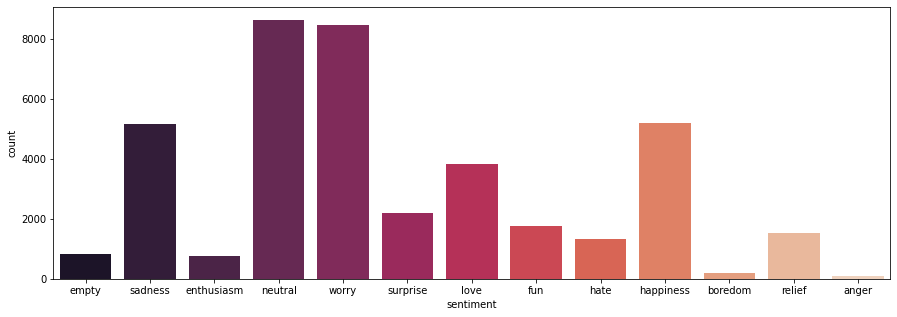

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
sns.countplot(x=data["sentiment"],palette="rocket")

In [ ]:
data.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [ ]:
print("Total number of labels: ",data['sentiment'].nunique())

Total number of labels:  13


Preprocessing the Text

In [ ]:
def processText(text):
    
    # Using the line tokenizer to split using new line character (\n) and discarding the blank lines
    if text is not None:
        
        lines = LineTokenizer(blanklines = 'discard').tokenize(text)

        sentences = []

        # For each line found above we are doing sentence tokenization
        for line in lines:
            currentSentences = sent_tokenize(line)
            # sentences.extend([sentence for sentence in currentSentences ])
            for sentence in currentSentences:
                currentText = str(sentence.encode("ascii", "ignore").decode().strip())
                sentences.extend([currentText])
                text = '. '.join([processSentence(sentence) for sentence in sentences])
    return text


# This function processes the sentence so that it can be used to produce meaningful embeddings
def processSentence(text):
    # Removing HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Removing new line characters
    text = text.replace('\\n', '')
    # Removing urls
    # text = re.sub('[^ ]+\.[^ ]+', ' ', text)
    text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]|\(([^\s()<>]|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))'''," ",text)
    # Removing email addresses
    text = re.sub(r'''\S*@\S*\s?''', " ", text)
    # Expanding the contractions
    text = contractions.fix(text)
    return text

In [ ]:
data['content']=data['content'].apply(lambda x: processSentence(x))
data['content']=data['content'].apply(lambda x: processText(x))

In [ ]:
data=data.drop(columns=['tweet_id'])

In [ ]:
data.head()

,sentiment,content
0,empty,i know i was listenin to bad habit earlier an...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,We want to trade with someone who has Houston ...


In [ ]:
data['sentiment'].unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

Encoding the Labels

In [ ]:
possible_labels = data.sentiment.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'empty': 0,
 'sadness': 1,
 'enthusiasm': 2,
 'neutral': 3,
 'worry': 4,
 'surprise': 5,
 'love': 6,
 'fun': 7,
 'hate': 8,
 'happiness': 9,
 'boredom': 10,
 'relief': 11,
 'anger': 12}

In [ ]:
data['label'] = data.sentiment.replace(label_dict)

In [ ]:
data.head()

,sentiment,content,label
0,empty,i know i was listenin to bad habit earlier an...,0
1,sadness,Layin n bed with a headache ughhhh...waitin o...,1
2,sadness,Funeral ceremony...gloomy friday...,1
3,enthusiasm,wants to hang out with friends SOON!,2
4,neutral,We want to trade with someone who has Houston ...,3


Splitting Data into Training and Validation subsets

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data.index.values, 
                                                  data.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=data.label.values)

In [ ]:
data['data_type'] = ['not_set']*data.shape[0]

data.loc[X_train, 'data_type'] = 'train'
data.loc[X_val, 'data_type'] = 'val'

Creating Tokens

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(
    data[data.data_type=='train'].content.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    data[data.data_type=='val'].content.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(data[data.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(data[data.data_type=='val'].label.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [ ]:
len(dataset_train), len(dataset_val)

(34000, 6000)

Model Definition

In [ ]:
model = RobertaForSequenceClassification.from_pretrained("roberta-base",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [ ]:
batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
epochs = 2

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [ ]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


Training and Evaluating the model

In [ ]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    # torch.save(model.state_dict(), f'data_volume/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

Streaming output truncated to the last 5000 lines.
  0%|          | 0/2 [35:20<?, ?it/s]


Epoch 1
Training loss: 1.4390182707071546


 50%|█████     | 1/2 [36:47<36:47, 2207.56s/it]

Validation loss: 2.011014933720231
F1 Score (Weighted): 0.3545562895137172


Streaming output truncated to the last 5000 lines.
 50%|█████     | 1/2 [1:12:07<36:47, 2207.56s/it]


Epoch 2
Training loss: 1.5654012314016823


100%|██████████| 2/2 [1:13:34<00:00, 2207.16s/it]

Validation loss: 1.8865824404731393
F1 Score (Weighted): 0.3656208960454162
